#                                **Automatic Report Generation From Chest X-Rays**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>Business Problem/Problem Statement :</h2>
    
> Clinical imaging captures enormous amounts of information but most radio-logic data are reported in qualitative and subjective terms. X-Rays are a form of Electromagnetic Radiation that is used for medical imaging. Analysis of X-ray reports is a very important task of radiologists and pathologists to recommend the correct diagnosis to the patients. In this project, we are tackling the image captioning problem for a dataset containing Chest X-ray images. With the help of the state of the art deep learning architecture and optimizing parameters of the architecture. The problem statement here is to find the impression from the given chest X-Ray images. These images are of two types: Frontal and Lateral view of the chest. With these two types of images as input we need to find the impression for given X-Ray. To resolve this problem statement, we will be building a predictive model which involves both image and text processing to build a deep learning model. Image captioning is an interesting problem, where we can learn both Natural Language Processing(NLP) and Computer Vision(CV) techniques.

<h2>Dataset Overview :</h2>

Data source : https://openi.nlm.nih.gov/

The dataset contains chest X-ray images and radiology text reports. Each image has been paired with four captions such as Impressions, Findings, Comparison and Indication that provide clear descriptions of the salient entities and events.

> Chest X-ray -There are 7,471 images in .png file format (contain lateral view and frontal view of each patient).

> Radiology Report -There are about 3955 patients text reports available in .XML format.

<h2>Mapping the real-world problem to Machine Learning problem :</h2>

> The problem we are going to solve in this case study is Medical Image Captioning. Basically, we have to extract features from images using a Convolutional Neural Network(CNN) from scratch or using transfer learning (preferable as we have less amount of data). Then use these extracted features to predict the captions using LSTMs or GRUs. The output would be a sequence of words.

<h2>Real-world constraints :</h2>

> Interpretability is moderately important.

> There are no latency constraints.

> As the cost of mistakes in the Medical domain is very high the model should be very good in its predictions. 


<h2>Performance Metric :</h2>

> To evaluate the model performance, I will use bilingual evaluation understudy (BLEU) score. BLEU is a well-acknowledged metric to measure the similarity of one hypothesis sentence to multiple reference sentences. Given a single hypothesis sentence and multiple reference sentences, it returns value between 0 and 1. The metric close to 1 means that the two are very similar. Apparently we need to have a higher BLEU score.
                           


### Import Libraries here

In [ ]:
from pathlib import Path
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from numpy import array
import pandas as pd
import string
import os
import glob
from time import time
from keras import models
from keras.applications import densenet
import shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import cv2
import warnings
import seaborn as sns
from tqdm import tqdm
sns.set_style("whitegrid")
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.model_selection import train_test_split

#### Unzip all the downloaded files

In [ ]:
cwd = os.getcwd()

In [ ]:
import tarfile
images = tarfile.open('/content/drive/MyDrive/NLMCXR_png.tgz')
images.extractall(cwd+'/images/')

In [ ]:
xml = tarfile.open('/content/drive/MyDrive/NLMCXR_reports.tgz')
xml.extractall(cwd+'/reports/')

**Below is the sample image and the report :**

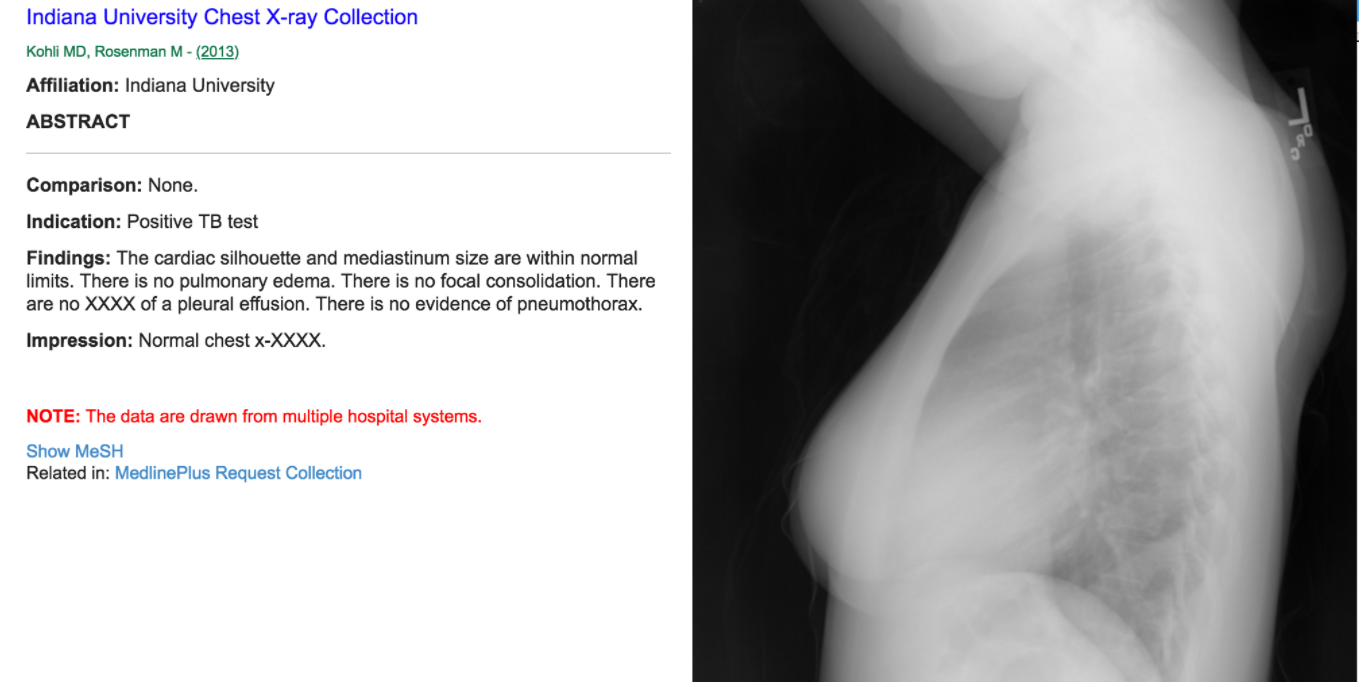

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/sample.PNG')

**Displaying Random images :**

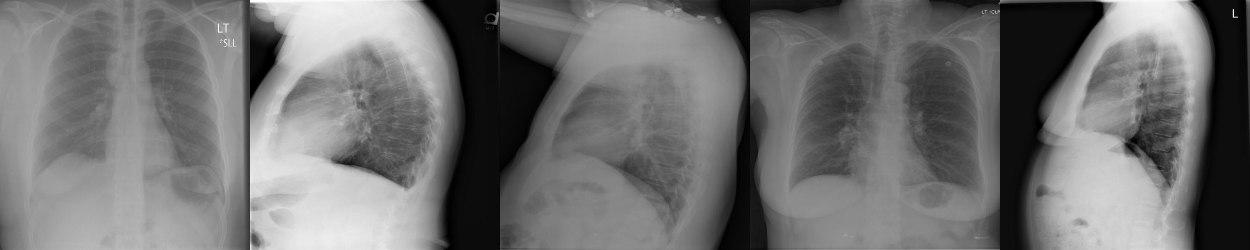

In [ ]:
#print 5 sample images
img_lst=[]
for i in range(0,5): 
  k = np.random.choice(range(len(os.listdir('/content/images'))))
  image_file = os.listdir('/content/images')[k]
  #getting an image file
  img = cv2.imread(os.path.join('/content/images',image_file))
  img = cv2.resize(img, (250, 250))
  img_lst.append(img)
img_lst = np.hstack(img_lst)
cv2_imshow(img_lst)

**Observation :**  X-Ray images are of human upper body particularly about Chest part.

**Display an XML :**

In [ ]:
with open("/content/reports/ecgen-radiology/1.xml", 'r') as f:
    print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1"/>
   <pmcId id="1"/>
   <docSource>CXR</docSource>
   <IUXRId id="1"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
            

**Observations :**

The fields which seem to be important and userful are :

* pmcid : Patient id
* COMPARISION
* INDICATION
* FINDINGS
* IMPRESSIONS (Target Variable)
* Image id

We can see there are two image files associated with this report. First I will check the stats of data. Then we will see the maximum and minimum possible value for number of images that are associated with a report.

**Checking the data stats :**

In [ ]:
print('Total Images in data : ', len(os.listdir('/content/images')))
print('Total Reports in data : ', len(os.listdir('/content/reports/ecgen-radiology')))

Total Images in data :  7471
Total Reports in data :  3955


Observations :

* There are 7471 images(X-rays) and 3955 reports in dataset.
* Few reports have more than image associated with them.

In [ ]:
#list of count of images
img_count = [] 
for file in os.listdir('/content/reports/ecgen-radiology'):
  xml_file = os.path.join('/content/reports/ecgen-radiology',file)
  #reading the xml data
  with open(xml_file, 'r') as f:  
    data = f.read()
  #getting all the image names
  regex = r"parentImage id.*" 
  k  = re.findall(regex,data)
  temp = len(k)
  img_count.append(temp)

print("The max number of images associated with a report:",np.array(img_count).max())
print("The min number of images associated with a report:",np.array(img_count).min())

The max number of images associated with a report: 5
The min number of images associated with a report: 0


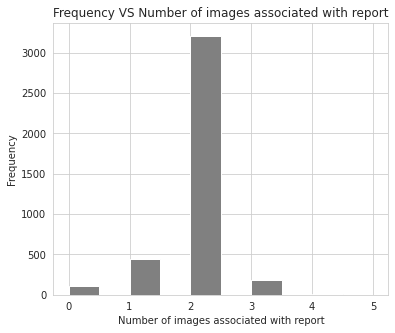

In [ ]:
plt.figure(figsize = (6,5))
ax = pd.Series(img_count).plot(kind='hist',color='grey')
ax.set_xlabel('Number of images associated with report')
ax.set_title("Frequency VS Number of images associated with report")
plt.show()

In [ ]:
print("Images per patient :\n")
print(pd.Series(img_count).value_counts())

Images per patient :

2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64


**Observation :**

We can see that the maximum number of images associated with a report can be 5 while the minimum is 0. The highest frequecy of being associated with a report are 2 images.

**Dataset Preparation :**

Reports are in xml format. Need to do xml parsing to read the data and convert it into csv format.

> **Input Features :** Images and we will also take abstract, comparison, indication, findings as text input features.

> **Target variable :** Impression (Text feature).

In [ ]:
#Reference : https://stackoverflow.com/questions/2723015/how-to-find-recursively-for-a-tag-of-xml-using-lxml

columns = ["image_name", "image_caption", "comparison", "indication", "findings", "impression"]
dataframe = pd.DataFrame(columns = columns)
for file in tqdm(os.listdir('/content/reports/ecgen-radiology/')):
    #find files with .xml extension only
    if file.endswith(".xml"):
        # finding root element 
        tree = ET.parse('/content/reports/ecgen-radiology/'+file)#parse the xml file
        
        findings = tree.find(".//AbstractText[@Label='FINDINGS']").text
        indication = tree.find(".//AbstractText[@Label='INDICATION']").text
        comparision = tree.find(".//AbstractText[@Label='COMPARISON']").text
        impression = tree.find(".//AbstractText[@Label='IMPRESSION']").text

        caption = set()
        name_img = set()
        #find images in each parentImage tag
        for iterator in tree.findall("parentImage"):
            img = iterator.attrib['id']+".png"
            name_img.add(img)
            #add the corresponding report for each image
            caption.add('' if iterator.find('caption').text is None else iterator.find('caption').text)
            
        # add image details and reports to dataframe
        dataframe = dataframe.append(pd.Series([','.join(name_img), ','.join(caption), comparision, indication, findings, impression],
                                                         index = columns), ignore_index = True)


100%|██████████| 3955/3955 [00:11<00:00, 330.81it/s]


In [ ]:
dataframe.head()

,image_name,image_caption,comparison,indication,findings,impression
0,"CXR780_IM-2323-1001.png,CXR780_IM-2323-2001.png",PA and Lateral Chest,None available.,Preop bilateral leg gangrene.,Heart size is upper limits of normal. Mediasti...,Clear lungs. No acute cardiopulmonary findings.
1,"CXR431_IM-2072-1002.png,CXR431_IM-2072-1001.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX XXXX","chest 2 views from XXXX, XXXX.",please XXXX for sarcoid/tuberculosis,The Heart size is normal. Cardiomediastinal si...,no radiographic evidence of tuberculosis or sa...
2,"CXR2462_IM-0995-1001.png,CXR2462_IM-0995-3001.png",CHEST (PA AND LATERAL),"XXXX, XXXX.",XXXX-year-old male with history of XXXX.,There is stable cardiomegaly. Aorta is calcifi...,1. Cardiomegaly and findings of prior asbestos...
3,"CXR115_IM-0102-1001.png,CXR115_IM-0102-2001.png",Xray Chest PA and Lateral,None,Right arm pain since this XXXX.,The lungs are clear. There is hyperinflation o...,COPD. No acute pulmonary disease.
4,"CXR1601_IM-0390-2001.png,CXR1601_IM-0390-1001.png",2 views Chest: XXXX,None.,Chest pain,The lungs and pleural spaces show no acute abn...,1. No acute pulmonary abnormality.


In [ ]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', dataframe.shape)

Shape of the Dataframe :  (3955, 6)


**Displaying Sample Images + Caption :**

In [ ]:
def show_image_captions(df,sample):
    '''This function prints the sample images and its other text features.
       Parameters :
       - df: dataframe
       - sample: Number of datapoints'''
    
    sampled_row = df.sample(sample)

    for count, row in sampled_row.iterrows():
        print("Caption :",row['image_caption'])
        imgs = row["image_name"].split(',')
        fig, axs = plt.subplots(1, len(imgs), figsize = (10,10))
        iterator = 0

        for img, figure in zip(imgs, axs.flat):
            image= mpimg.imread("/content/images/"+img)
            imgplot = axs[iterator].imshow(image)
            iterator +=1
        
        plt.show()
        #print("\nComparision :",row.get('comparision'))
        #print("\nIndication :",row.get('indication'))
        print("\nFindings :",row.get('findings'))
        print("\nImpression :",row.get('impression'))
        print("="*100,'\n')

Caption : PA and lateral chest x-XXXX XXXX. 


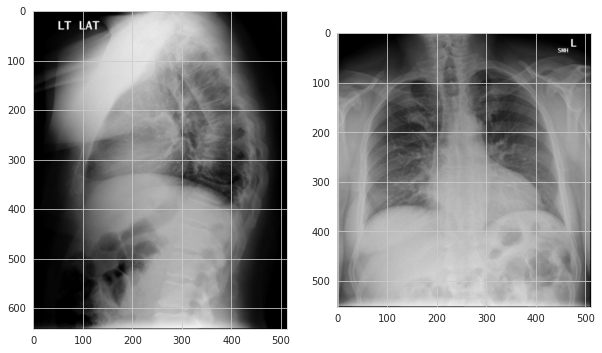


Findings : Heart size within normal limits. There are low lung volumes with bronchovascular crowding. There is mild increased airspace opacity within the right lung base which may represent atelectasis or infiltrate.. No visualized pneumothorax or large pleural effusion. Multilevel degenerative disease of the spine.

Impression : Low lung volumes with airspace disease within the right lung base. Followup radiographs following treatment is recommended to document resolution.



In [ ]:
#showing sample 1 datapoint
show_image_captions(dataframe, 1)

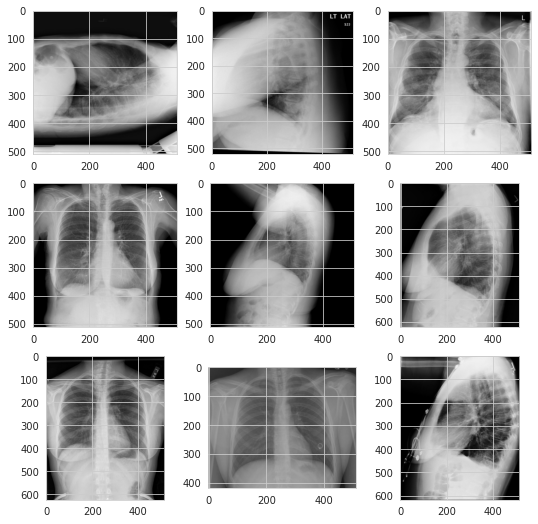

In [ ]:
#Displaying sample 9 patient X-Ray
fig, axs = plt.subplots(3, 3, figsize = (9,9))
ax = axs.flatten()
for df, figure in zip(dataframe[0:10].itertuples(), ax):
    image=mpimg.imread("/content/images/"+df.image_name.split(',')[0])
    figure.imshow(image)
plt.show()

In [ ]:
dataframe = dataframe[['image_name','image_caption',	'findings','impression']]

In [ ]:
dataframe.head()

,image_name,image_caption,findings,impression
0,"CXR780_IM-2323-1001.png,CXR780_IM-2323-2001.png",PA and Lateral Chest,Heart size is upper limits of normal. Mediasti...,Clear lungs. No acute cardiopulmonary findings.
1,"CXR431_IM-2072-1002.png,CXR431_IM-2072-1001.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX XXXX",The Heart size is normal. Cardiomediastinal si...,no radiographic evidence of tuberculosis or sa...
2,"CXR2462_IM-0995-1001.png,CXR2462_IM-0995-3001.png",CHEST (PA AND LATERAL),There is stable cardiomegaly. Aorta is calcifi...,1. Cardiomegaly and findings of prior asbestos...
3,"CXR115_IM-0102-1001.png,CXR115_IM-0102-2001.png",Xray Chest PA and Lateral,The lungs are clear. There is hyperinflation o...,COPD. No acute pulmonary disease.
4,"CXR1601_IM-0390-2001.png,CXR1601_IM-0390-1001.png",2 views Chest: XXXX,The lungs and pleural spaces show no acute abn...,1. No acute pulmonary abnormality.


In [ ]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', dataframe.shape)

Shape of the Dataframe :  (3955, 4)


**Preprocessing :**

In [ ]:
dataframe[dataframe["findings"]==''].count()

image_name       0
image_caption    0
findings         0
impression       0
dtype: int64

In [ ]:
dataframe[dataframe["impression"]==''].count()

image_name       0
image_caption    0
findings         0
impression       0
dtype: int64

In [ ]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in image name columns -",NaN[0])
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in findings columns   -",NaN[2])
print("Total Nan Values in Impression columns -",NaN[3])

Total Nan Values in image name columns - 0
Total Nan Values in caption columns - 0
Total Nan Values in findings columns   - 530
Total Nan Values in Impression columns - 34


In [ ]:
dataframe['findings'] = dataframe['findings'].fillna(dataframe["impression"])

In [ ]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in image name columns -",NaN[0])
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in findings columns   -",NaN[2])
print("Total Nan Values in Impression columns -",NaN[3])

Total Nan Values in image name columns - 0
Total Nan Values in caption columns - 0
Total Nan Values in findings columns   - 28
Total Nan Values in Impression columns - 34


In [ ]:
dataframe['findings'] = dataframe['findings'].fillna('No Findings')
dataframe['impression'] = dataframe['impression'].fillna('No Impression')

In [ ]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in image name columns -",NaN[0])
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in findings columns   -",NaN[2])
print("Total Nan Values in Impression columns -",NaN[3])

Total Nan Values in image name columns - 0
Total Nan Values in caption columns - 0
Total Nan Values in findings columns   - 0
Total Nan Values in Impression columns - 0


In [ ]:
dataframe.head()

,image_name,image_caption,findings,impression
0,"CXR780_IM-2323-1001.png,CXR780_IM-2323-2001.png",PA and Lateral Chest,Heart size is upper limits of normal. Mediasti...,Clear lungs. No acute cardiopulmonary findings.
1,"CXR431_IM-2072-1002.png,CXR431_IM-2072-1001.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX XXXX",The Heart size is normal. Cardiomediastinal si...,no radiographic evidence of tuberculosis or sa...
2,"CXR2462_IM-0995-1001.png,CXR2462_IM-0995-3001.png",CHEST (PA AND LATERAL),There is stable cardiomegaly. Aorta is calcifi...,1. Cardiomegaly and findings of prior asbestos...
3,"CXR115_IM-0102-1001.png,CXR115_IM-0102-2001.png",Xray Chest PA and Lateral,The lungs are clear. There is hyperinflation o...,COPD. No acute pulmonary disease.
4,"CXR1601_IM-0390-2001.png,CXR1601_IM-0390-1001.png",2 views Chest: XXXX,The lungs and pleural spaces show no acute abn...,1. No acute pulmonary abnormality.


In [ ]:
dataframe.shape

(3955, 4)

In [ ]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [ ]:
def preprocess_text(data): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  preprocessed = []

  for sentence in tqdm(data.values):

    sentence = BeautifulSoup(sentence, 'lxml').get_text()

    regex = r"\d." 
    sentence = re.sub(regex,"",sentence) #removing all values like "1." and "2." etc

    regex = r"X+"
    sentence = re.sub(regex,"",sentence) #removing words like XXXX

    regex = r"[^.a-zA-Z]" 
    sentence = re.sub(regex," ",sentence) #removing all special characters except for full stop

    regex = r"http\S+"
    sentence = re.sub(regex,"", sentence)
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?$%^&*'/+\[\]_]+", "", sentence)
    sentence = re.sub('&', 'and',sentence)
    sentence = re.sub('@', 'at',sentence)
    sentence = re.sub('/', 'or',sentence)
    sentence = sentence.replace('-', ' ')
    sentence = sentence.replace('<BR>', ' ')
    sentence = sentence.replace('&gt;]', '')
    sentence = sentence.replace('[&lt;', '')
    sentence = re.sub('0', 'zero',sentence)
    sentence = re.sub('1', 'one',sentence)
    sentence = re.sub('2', 'two',sentence)
    sentence = re.sub('3', 'three',sentence)
    sentence = re.sub('4', 'four',sentence)
    sentence = re.sub('5', 'five',sentence)
    sentence = re.sub('6', 'six',sentence)
    sentence = re.sub('7', 'seven',sentence)
    sentence = re.sub('8', 'eight',sentence)
    sentence = re.sub('9', 'nine',sentence)
    sentence = re.sub('year old', "", sentence)#Occur multiple times in Indication feature but not necessary     
    sentence = re.sub('yearold', "", sentence)
    sentence = decontracted(sentence) #perform decontraction
    sentence = sentence.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
    sentence = " ".join(sentence.split()) #removes unwanted spaces
    if sentence=="": #if the resulting sentence is an empty string return null value
      sentence = np.nan
    preprocessed.append(sentence)
  return preprocessed

In [ ]:
#Preprocessing of text features
dataframe['image_caption'] = preprocess_text(dataframe['image_caption'])
dataframe['findings'] = preprocess_text(dataframe['findings'])
dataframe['impression'] = preprocess_text(dataframe['impression'])

100%|██████████| 3955/3955 [00:01<00:00, 3612.86it/s]


In [ ]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in image name columns -",NaN[0])
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in findings columns   -",NaN[2])
print("Total Nan Values in Impression columns -",NaN[3])

Total Nan Values in image name columns - 0
Total Nan Values in caption columns - 106
Total Nan Values in findings columns   - 1
Total Nan Values in Impression columns - 0


In [ ]:
dataframe['findings'] = dataframe['findings'].fillna('No Findings')
dataframe['image_caption'] = dataframe['image_caption'].fillna('No captions')


In [ ]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in image name columns -",NaN[0])
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in findings columns   -",NaN[2])
print("Total Nan Values in Impression columns -",NaN[3])

Total Nan Values in image name columns - 0
Total Nan Values in caption columns - 0
Total Nan Values in findings columns   - 0
Total Nan Values in Impression columns - 0


In [ ]:
dataframe.head()

,image_name,image_caption,findings,impression
0,"CXR780_IM-2323-1001.png,CXR780_IM-2323-2001.png",pa and lateral chest,heart size is upper limits of normal mediastin...,clear lungs no acute cardiopulmonary findings
1,"CXR431_IM-2072-1002.png,CXR431_IM-2072-1001.png",chest frontal lateral,the heart size is normal cardiomediastinal sil...,no radiographic evidence of tuberculosis or sa...
2,"CXR2462_IM-0995-1001.png,CXR2462_IM-0995-3001.png",chest pa and lateral,there is stable cardiomegaly aorta is calcifie...,cardiomegaly and findings of prior asbestos ex...
3,"CXR115_IM-0102-1001.png,CXR115_IM-0102-2001.png",ray chest pa and lateral,the lungs are clear there is hyperinflation of...,copd no acute pulmonary disease
4,"CXR1601_IM-0390-2001.png,CXR1601_IM-0390-1001.png",views chest,the lungs and pleural spaces show no acute abn...,no acute pulmonary abnormality


**Observation :** 

* I did some text preprocessing in XML, for four labels (comparision,indcation, impression and findings). I analyze the text data, then perform tasks like decontraction (can't ---> can not), remove special character, convert in lowercase.

* I have also preprocessed Image caption feature, For getting additional information about the corrosponding image.

* Missing values are also present in image_name feature. As at some place nothing is assigned on image_name.

**Add Image count feature :**

In [ ]:
dataframe['image_count'] = dataframe['image_name'].astype(str).str.split(',').apply(len)

**Adding word count feature for findings and impression :**

In [ ]:
#Adding word count feature for indication, findings and impression
dataframe['findings_count'] = dataframe['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe['impression_count'] = dataframe['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe.head()

,image_name,image_caption,findings,impression,image_count,findings_count,impression_count
0,"CXR780_IM-2323-1001.png,CXR780_IM-2323-2001.png",pa and lateral chest,heart size is upper limits of normal mediastin...,clear lungs no acute cardiopulmonary findings,2,49,6
1,"CXR431_IM-2072-1002.png,CXR431_IM-2072-1001.png",chest frontal lateral,the heart size is normal cardiomediastinal sil...,no radiographic evidence of tuberculosis or sa...,2,46,7
2,"CXR2462_IM-0995-1001.png,CXR2462_IM-0995-3001.png",chest pa and lateral,there is stable cardiomegaly aorta is calcifie...,cardiomegaly and findings of prior asbestos ex...,2,31,12
3,"CXR115_IM-0102-1001.png,CXR115_IM-0102-2001.png",ray chest pa and lateral,the lungs are clear there is hyperinflation of...,copd no acute pulmonary disease,2,28,5
4,"CXR1601_IM-0390-2001.png,CXR1601_IM-0390-1001.png",views chest,the lungs and pleural spaces show no acute abn...,no acute pulmonary abnormality,2,17,4


<h3>Exploring the Image features :</h3>

**Displaying sample 9 patient X-Ray :**

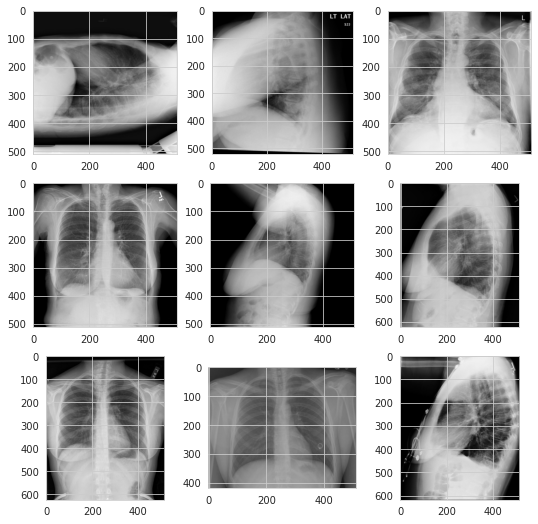

In [ ]:
#Displaying sample 9 patient X-Ray
fig, axs = plt.subplots(3, 3, figsize = (9,9))
ax = axs.flatten()
for df, figure in zip(dataframe[0:10].itertuples(), ax):
    image=mpimg.imread("/content/images/"+df.image_name.split(',')[0])
    figure.imshow(image)
plt.show()

Caption : pa and lateral chest at comparison


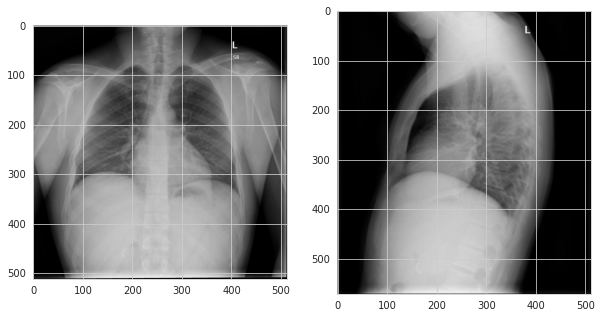


Findings : heart size is normal and lungs are clear no evidence of tuberculosis

Impression : heart size is normal and lungs are clear no evidence of tuberculosis



In [ ]:
#showing sample 2 datapoints
show_image_captions(dataframe, 1)

**Observations :**

* Images are in different shapes.
* All the X-Ray images are human upper body particularly about Chest part.

In [ ]:
dataframe.to_csv("data_1.csv", index=False)
!cp data_1.csv "/content/drive/MyDrive"
dataframe = pd.read_csv('/content/drive/MyDrive/data_1.csv')

<h3>Exploring the Text features :</h3>


In [ ]:
def unique_words_features(df):
    '''This function takes pandas dataframe and show barplot of features unique and repeated words 
       Input  =  pandas dataframe or numpy arrays
       Output =  barplot of the unique words of dataframe '''

    #length of the feature
    len_total = len(df.tolist())

    #length of unique words in the featue
    len_unique = len(np.unique(df.tolist()))

    x = ['Total Values', 'Unique Values']
    y =  [len_total, len_unique]

    plt.bar(x,y,color = 'Teal')
    plt.ylabel('Word-Count')
    for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
    
    plt.ylabel('Word-Count')

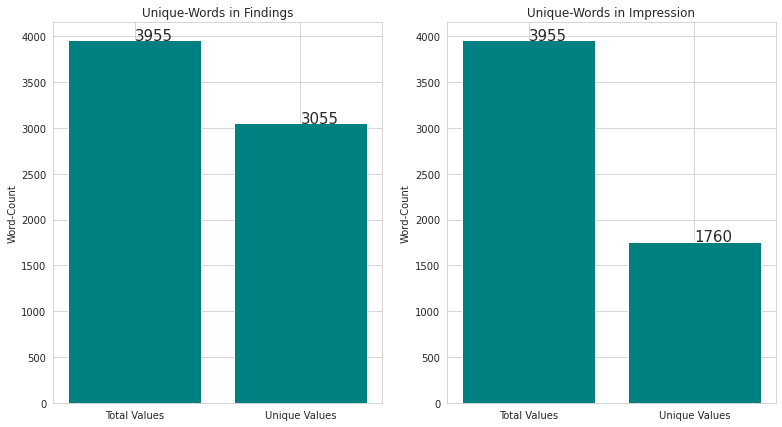

In [ ]:
plt.figure(figsize = (20,7))

plt.subplot(132)
unique_words_features(dataframe['findings'])
plt.title('Unique-Words in Findings')
plt.subplot(133)
unique_words_features(dataframe['impression'])
plt.title('Unique-Words in Impression')
plt.show()

**Observation :** We conclude from above features bar plot, That all of them are text features as there are total 3851 entries and a good chunk of values are unique in all of them i.e, They never repeated. So, they can not be categorical features.

In [ ]:
#Printing min,max and median of word_count
print("Maximum number of word count for Impression is:",np.max(dataframe.impression_count.values))
print("Minimum number of word count for Impression is:",np.min(dataframe.impression_count.values))
print("Median number of word count for Impression is:",np.median(dataframe.impression_count.values))

Maximum number of word count for Impression is: 123
Minimum number of word count for Impression is: 1
Median number of word count for Impression is: 5.0


Plotting PDF and CDF for word_count distribution of Indication feature :

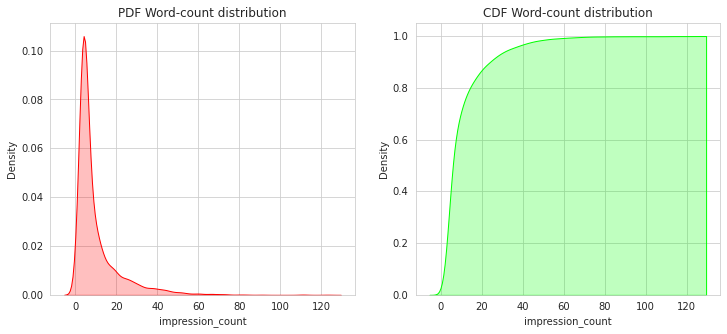

In [ ]:
#Plotting PDF and CDF for word_count distribution of Impression feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['impression_count'],shade=True,color='Red')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['impression_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Impression feature :

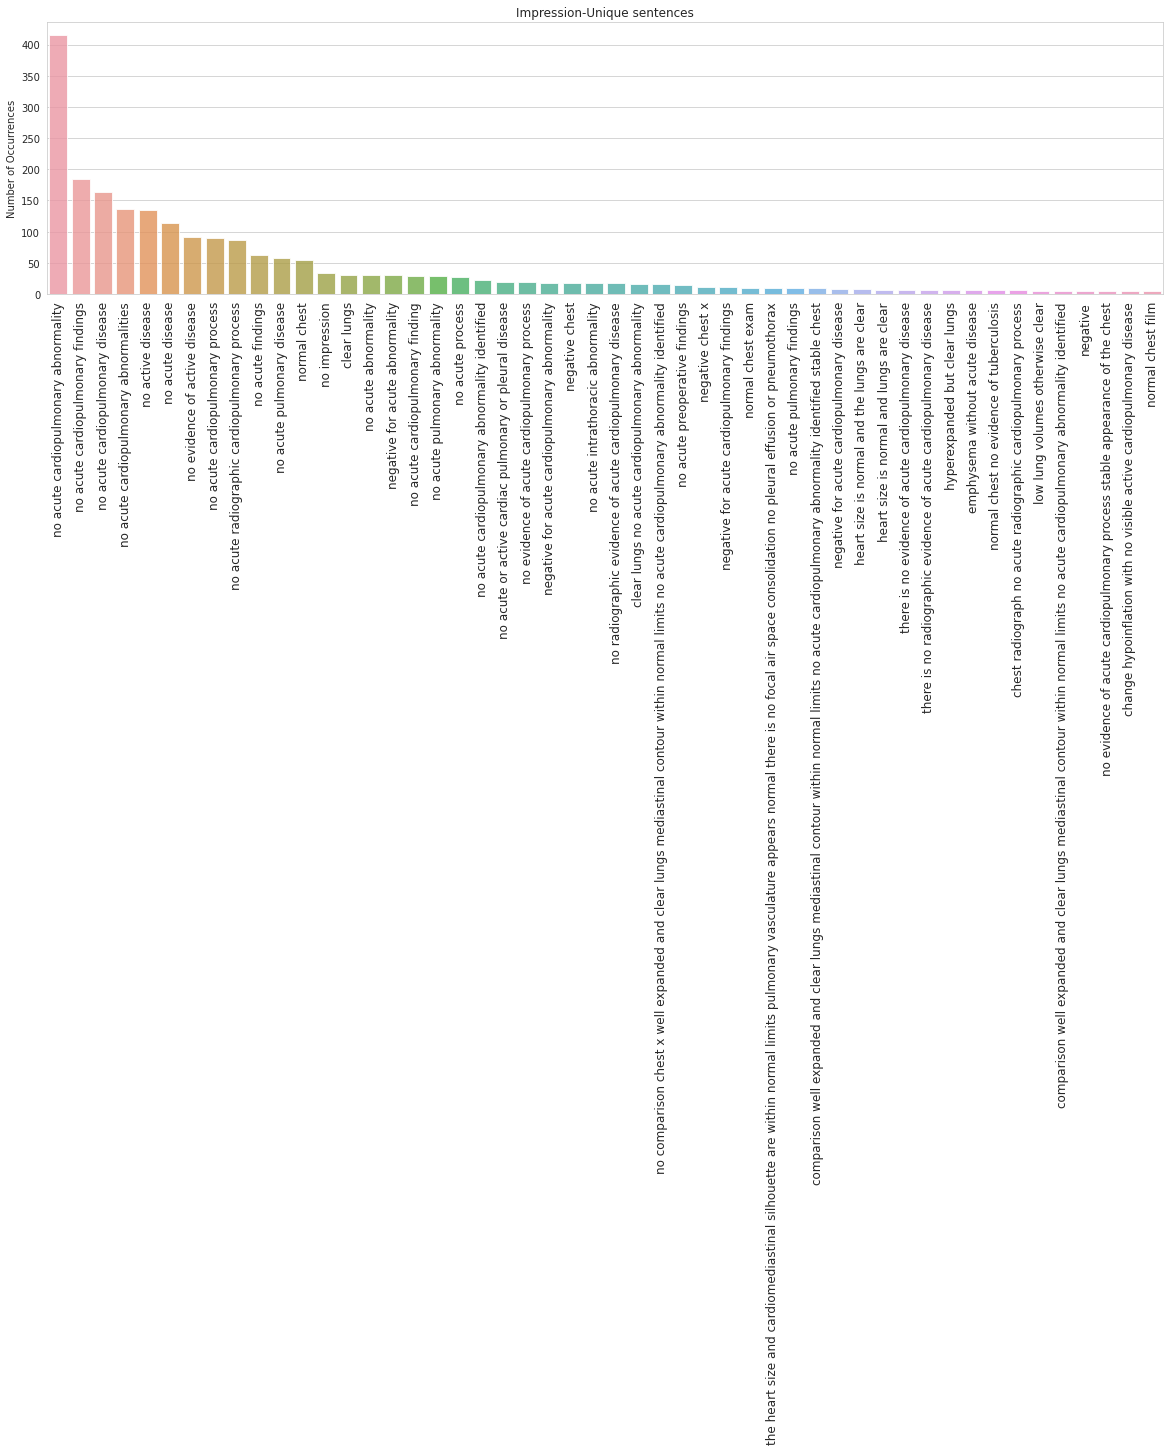

In [ ]:
#Plotting top 50 frequent sentences of Impression feature
sentences = dataframe['impression'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Impression-Unique sentences")
plt.show()

Word cloud on Impression feature : max 500 words

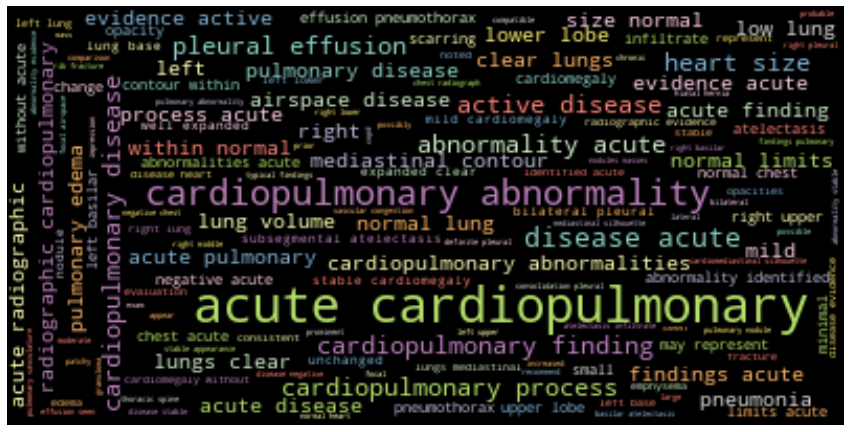

In [ ]:
#Word cloud on Impression feature
dictionary = WordCloud(max_words=500, background_color="black", colormap="Set3")
plt.figure(figsize=(15,10))
plt.imshow(dictionary.generate(' '.join(dataframe.impression.astype(str))), interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Indication feature :**

* Top two most impression are 'actue cardiopulmonary abnormality' and 'actue cardiopulmonary findings' above 400 counts in feature.
* In indication feature, 50% data have less than 4 words per impression, it means only few impression have less words. 99% data have less than 39 words per impression. Only 1% data have legnth above 39.
* From wordcloud : actue cardiopulmonary, cardiopulmonary abnormality, disease acute, heart size are the highlighted words i.e. these are important words.

**Analysis of Target feature : Findings**

**Note :** I consider finding features as Target variable, as it has much data volume and from sample data points, It is clear that this feature gives most of the information present in images.

In [ ]:
#Printing min,max and median of word_count
print("Maximum number of word count for finding is:",np.max(dataframe.findings_count.values))
print("Minimum number of word count for finding is:",np.min(dataframe.findings_count.values))
print("Median number of word count for finding is:",np.median(dataframe.findings_count.values))

Maximum number of word count for finding is: 166
Minimum number of word count for finding is: 1
Median number of word count for finding is: 28.0


Plotting PDF and CDF for word_count distribution of Findings feature :

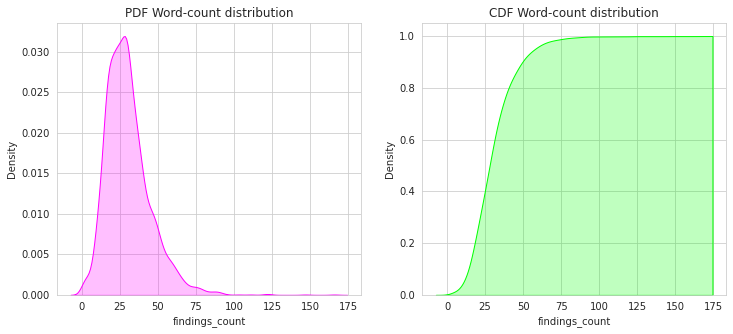

In [ ]:
#Plotting the PDF for word_count distribution of Findings feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['findings_count'],shade=True,color='Magenta')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['findings_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Findings feature :

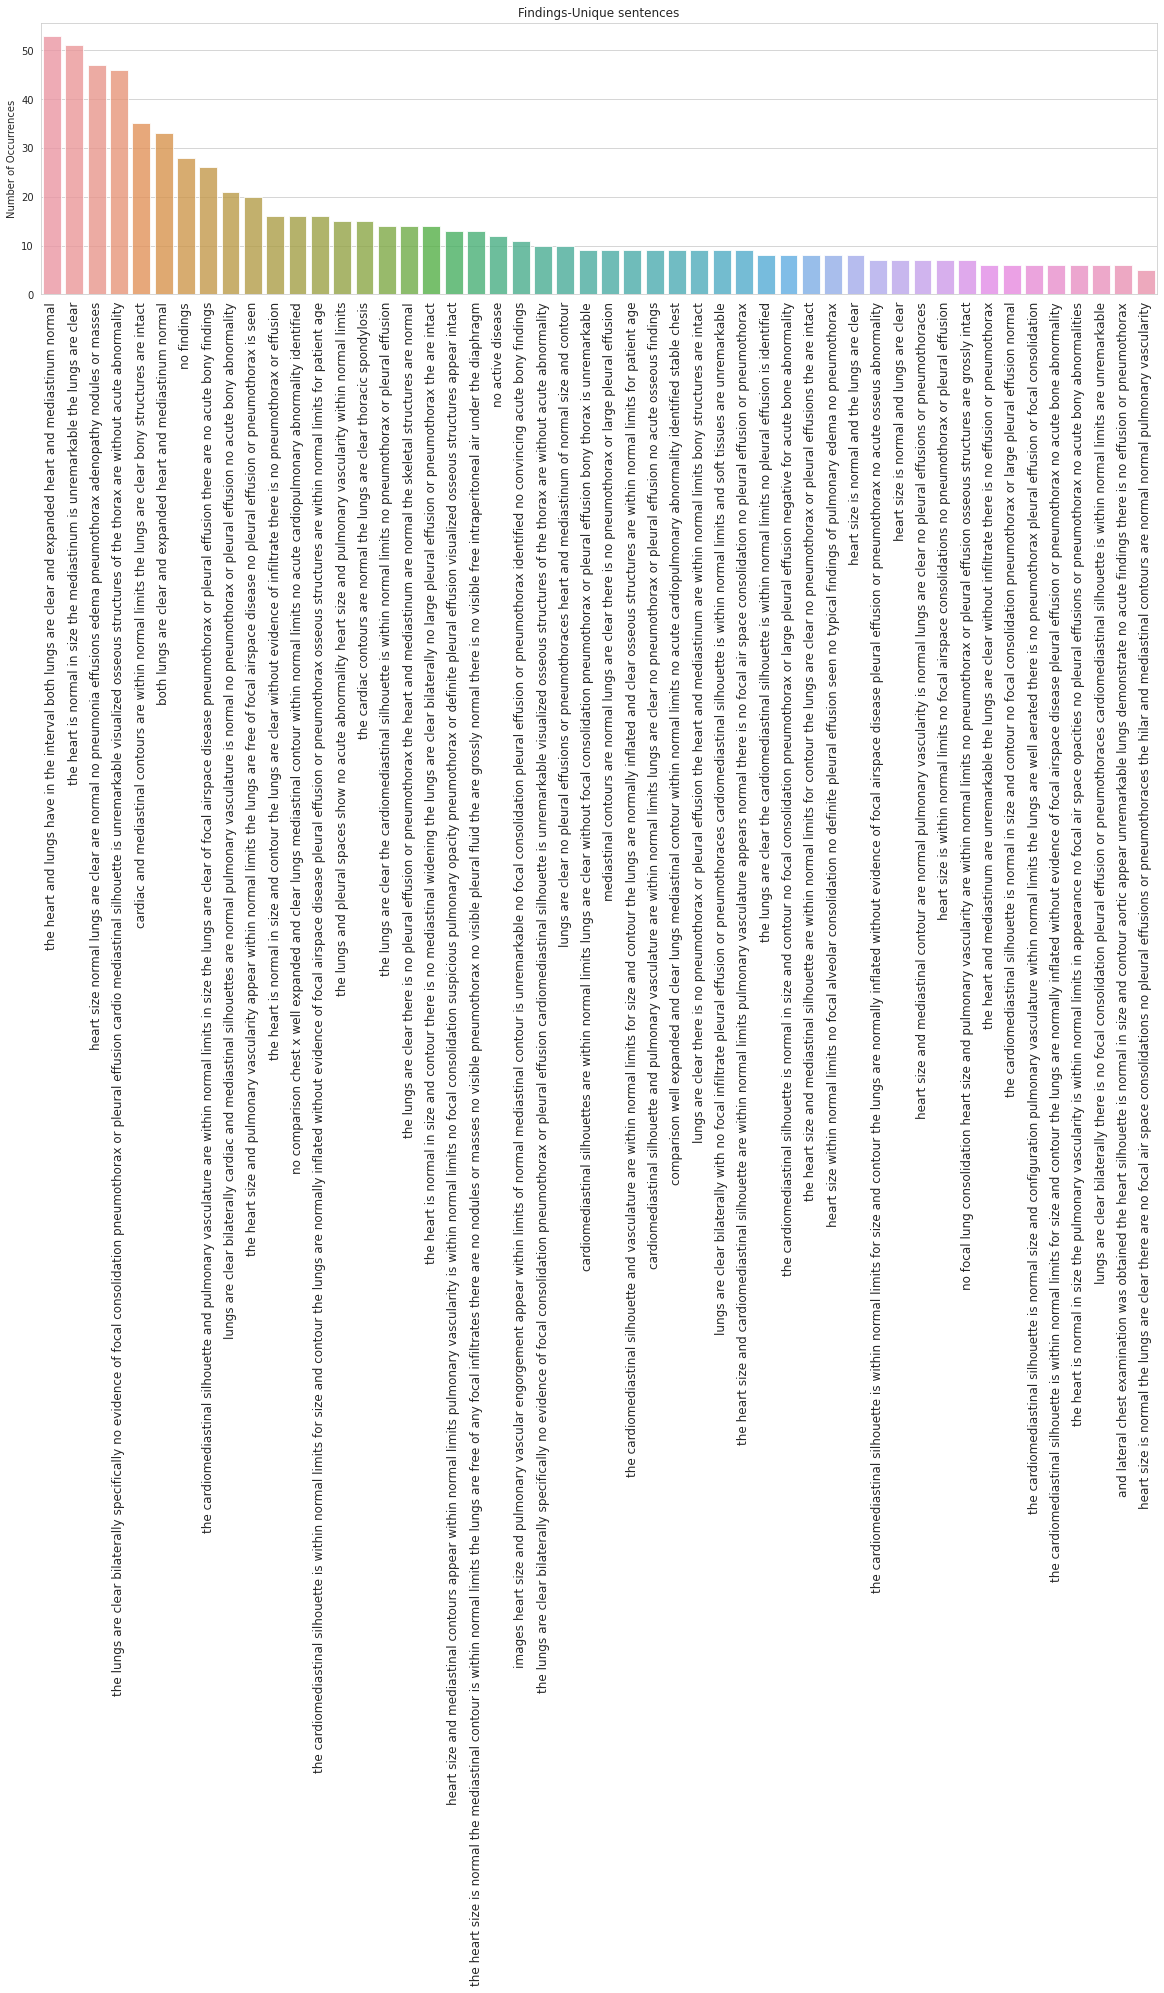

In [ ]:
#Plotting top 50 frequent sentences of Findings feature
sentences = dataframe['findings'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Findings-Unique sentences")
plt.show()

Word cloud on Findings feature : max 500 words

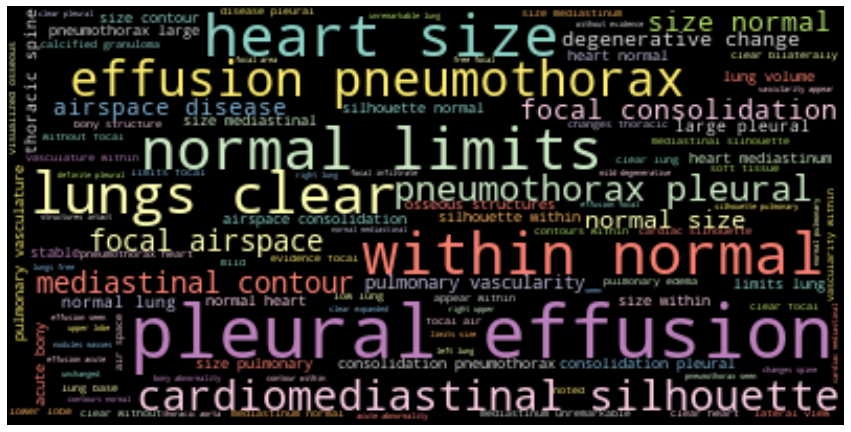

In [ ]:
#Word cloud on Findings feature
dictionary = WordCloud(max_words=500, background_color="black", colormap="Set3")
plt.figure(figsize=(15,10))
plt.imshow(dictionary.generate(' '.join(dataframe.findings.astype(str))), interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Findings feature :**

* In finding feature, 50% data have less than 20 words per findings, 99% data have less than 65 words per findings. Only 1% data have legnth above 48.
* From wordcloud : pleural, effusion, silhouette, within, normal, lungs, cardiomediastinal are the highlighted words i.e. these are important words.

**Total Observations from EDA:**

* The dataset contains chest X-ray images and radiology text reports. Each image has been paired with four captions such as Impressions, Findings, Comparison and Indication that provide clear descriptions of the salient entities and events. All the raw texts from xml files are parsed and created the dataset.

* I consider finding features as Target variable, as it has much data volume and from sample data points, It is clear that this feature gives most of the information present in images.

* Images are in different shapes. All the X-Ray images are human upper body particularly about Chest part.

* Each patient have multiple x-rays associated with them. The maximum number of images associated with a report can be 5 while the minimum is 0. The highest frequency of being associated with a report are 2 images.

* Data is incomplete. Because all the features have few missing values except caption. We have to impute the missing values in data preprocessing step.

* In text features there are some unknown values like XXXX XXXXX these are replaced with empty string.

* We have total of 3955 records and Findings is our target variable.

* Most occurring words of diffrent features:
    
    > Findings: Pleural effusion

    > Impression: acute cardiopulmonary

* I created wordcloud, for 500 most frequent words of the feature. These are important words. Some of them are: acute, findings, disease, abnormality, high, right, impression, etc.